## Create the Inception Model and Load the pre-trained Weights

In [1]:
# dlib==19.9.0 required for face alignment

import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

from model import create_model

InceptionModel = create_model()
InceptionModel.load_weights('data/weights/nn4.small2.v1.h5')

Using TensorFlow backend.


Instructions for updating:
dim is deprecated, use axis instead


## Define a Triplet Loss Layer and Create Model

In [ ]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The InceptionModel model instance is shared (Siamese network)
emb_a = InceptionModel(in_a)
emb_p = InceptionModel(in_p)
emb_n = InceptionModel(in_n)

loss = 'lossful'

# Lossless Triplet Loss Layer
# (https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24)
class LosslessTripletLossLayer(Layer):

    def __init__(self, N=3, beta=3, epsilon=1e-8, **kwargs):
        self.N = N
        self.beta = beta
        self.epsilon = epsilon
        super(LosslessTripletLossLayer, self).__init__(**kwargs)
    
    def lossless_triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a - p), axis=-1)
        n_dist = K.sum(K.square(a - n), axis=-1)
        pos_dist = - K.log(-(p_dist / self.beta) + 1 + self.epsilon)
        neg_dist = - K.log(- ((self.N - n_dist) / self.beta) + 1 + self.epsilon)
        return neg_dist + pos_dist
    
    def call(self, inputs):
        loss = self.lossless_triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Triplet Loss Layer
class TripletLossLayer(Layer):
    
    def __init__(self, alpha=0.2, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a - p), axis=-1)
        n_dist = K.sum(K.square(a - n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

## Load the Data Generator for triplet pairs and Fit the Model

In [ ]:
from data import triplet_generator

if loss == 'lossless':
    # Layer that computes the lossless triplet loss from anchor, positive and negative embedding vectors
    triplet_loss_layer = LosslessTripletLossLayer(name='lossless_triplet_loss_layer')([emb_a, emb_p, emb_n])
else:
    # Layer that computes the triplet loss from anchor, positive and negative embedding vectors
    triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
SiameseTripletNet = Model([in_a, in_p, in_n], triplet_loss_layer)
SiameseTripletNet.compile(optimizer='adam', loss=None, metrics=['accuracy'])

batch_size = 4

# triplet_generator() creates a generator that continuously returns 
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# and n_batch are batches of anchor, positive and negative RGB images 
# each having a shape of (batch_size, 96, 96, 3).
generator = triplet_generator(batch_size)

SiameseTripletNet.fit_generator(generator, epochs=10, steps_per_epoch=100)

# Please note that the current implementation of the generator only generates 
# random image data. The main goal of this code snippet is to demonstrate 
# the general setup for model training. In the following, we will anyway 
# use a pre-trained model so we don't need a generator here that operates 
# on real training data. I'll maybe provide a fully functional generator
# later.

## Create Metadata for image files

In [25]:
import numpy as np
import os
import cv2
from skimage.io import imread
from skimage.transform import resize

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

class Image():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()
    
    def show_name(self):
        return self.name.replace('_', ' ')

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    classes = os.listdir(path)
    for class_folder in classes:
        for image in os.listdir(os.path.join(path, class_folder)):
            metadata.append(Image(path, class_folder, image))
    return np.array(metadata), classes

train_metadata, classes = load_metadata('data/images/train')
test_metadata, _ = load_metadata('data/images/test')

print('Loaded {} training images of {} classes'
      .format(len(train_metadata), len(classes)))
print('Loaded {} testing images of {} classes'
      .format(len(test_metadata), len(classes)))

Loaded 213 training images of 17 classes
Loaded 33 testing images of 17 classes


### Test the Face Alignment feature

Madonna


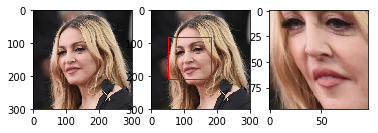

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('data/model/landmarks.dat')

def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

def show_aligned_pair(index, metadata=train_metadata):
    
    print(metadata[index].show_name())
    
    # Load original image
    jc_orig = load_image(metadata[index].image_path())
    
    # Show original image
    plt.subplot(131)
    plt.imshow(jc_orig)
    
    # Detect face and return bounding box
    bb = alignment.getLargestFaceBoundingBox(jc_orig)
    
    # Show original image with bounding box
    plt.subplot(132)
    plt.imshow(jc_orig)
    plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

    # Show aligned image
    jc_aligned = align_image(jc_orig)
    plt.subplot(133)
    plt.imshow(jc_aligned);
    
# Load an image of Madonna
show_aligned_pair(140)

In [29]:
def image_to_embedding(image):
    img = align_image(image)
    # check for NoneType returned error
    if img is None:
        return None
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedding = InceptionModel.predict(np.expand_dims(img, axis=0))[0]
    return embedding

def get_embeddings(metadata=train_metadata):
    
    embedded = np.zeros((metadata.shape[0], 128))
    errors = []
    
    for i, m in enumerate(metadata):
        img = load_image(m.image_path())
        emb = image_to_embedding(img)
        if emb is None:
            errors.append(m)
        embedded[i] = emb

    if len(errors) is not 0:
        print('Errors detected in the following files: ')
        print(errors)
        
    return embedded, errors

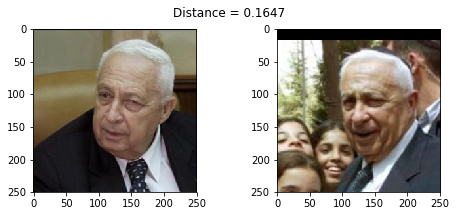

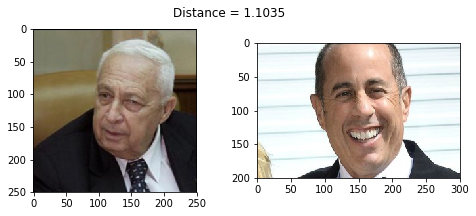

In [30]:
embedded_train, _ = get_embeddings(train_metadata)
embedded_test, _ = get_embeddings(test_metadata)

def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2, embedded=embedded_train, metadata=train_metadata):
    plt.figure(figsize=(8,3))
    plt.suptitle('Distance = {:.4f}'.format(distance(embedded[idx1], embedded[idx2])))
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 113)

## Calculate Optimal Threshold Value based on F1 Scores

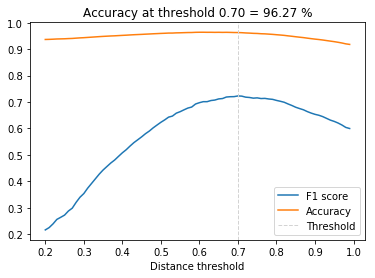

In [31]:
from sklearn.metrics import f1_score, accuracy_score

def calculate_optimal_threshold(embedded=embedded_train, metadata=train_metadata):

    distances = [] # squared L2 distance between pairs
    identical = [] # 1 if same identity, 0 otherwise

    num = len(metadata) # number of samples

    # Iterate over all embeddings to 
    # calculate distances between them
    for i in range(num - 1):
        for j in range(1, num):
            # Save the distance between embeddings
            distances.append(distance(embedded[i], embedded[j]))
            # 1 if same person, 0 otherwise
            identical.append(1 if metadata[i].name == metadata[j].name else 0)

    distances = np.array(distances)
    identical = np.array(identical)

    thresholds = np.arange(0.2, 1.0, 0.01)

    f1_scores = [f1_score(identical, distances < t) for t in thresholds]
    acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

    opt_idx = np.argmax(f1_scores)
    # Threshold at maximal F1 score
    opt_tau = thresholds[opt_idx]
    # Accuracy at maximal F1 score
    opt_acc = accuracy_score(identical, distances < opt_tau)

    # Plot F1 score and accuracy as function of distance threshold
    plt.plot(thresholds, f1_scores, label='F1 score');
    plt.plot(thresholds, acc_scores, label='Accuracy');
    plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
    plt.title('Accuracy at threshold {:.2f} = {:.2f} %'.format(opt_tau, opt_acc * 100));
    plt.xlabel('Distance threshold')
    plt.legend();
    
    return opt_tau, opt_acc, distances, identical
    
# set the value of optimal threshold
optimal_threshold, optimal_accuracy, distances, identical = calculate_optimal_threshold()

## Plot Distance Distributions of Positive and Negative Pairs

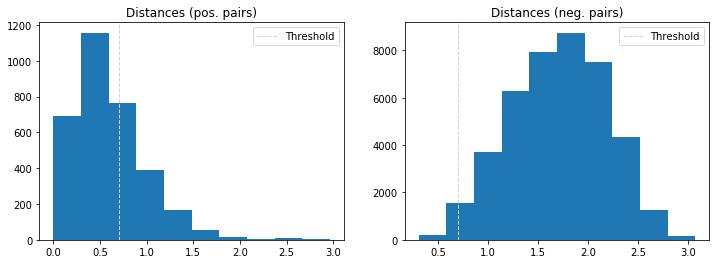

In [32]:
def plot_distance_distros(distances, identical):
    dist_pos = distances[identical == 1]
    dist_neg = distances[identical == 0]

    plt.figure(figsize=(12,4))

    plt.subplot(121)
    plt.hist(dist_pos)
    plt.axvline(x=optimal_threshold, linestyle='--', lw=1, c='lightgrey', label='Threshold')
    plt.title('Distances (pos. pairs)')
    plt.legend();

    plt.subplot(122)
    plt.hist(dist_neg)
    plt.axvline(x=optimal_threshold, linestyle='--', lw=1, c='lightgrey', label='Threshold')
    plt.title('Distances (neg. pairs)')
    plt.legend();

plot_distance_distros(distances, identical)

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets_train = np.array([m.name for m in train_metadata])
targets_test = np.array([m.name for m in test_metadata])

encoder = LabelEncoder()
encoder.fit(classes)

# Numerical encoding of identities/labels/classes
y_train = encoder.transform(targets_train)
y_test = encoder.transform(targets_test)

train_idx = np.arange(train_metadata.shape[0])
test_idx = np.arange(test_metadata.shape[0])

# 182 train examples of 15 identities (~12 examples each)
X_train = embedded_train
# 30 test examples of 15 identities (2 examples each)
X_test = embedded_test

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print('KNN accuracy = {:.2f}, SVM accuracy = {:.2f}'.format(acc_knn, acc_svc))

KNN accuracy = 1.00, SVM accuracy = 0.97


In [34]:
def create_database(embeddings=X_train, labels=y_train, encoder=encoder):

    labels = encoder.classes_
    
    class_to_idx = {}
    idx_to_class = {}
    database = {}
    
    for i, label in enumerate(labels):
        class_to_idx[label] = i
        idx_to_class[i] = label
        
    for label in labels:
        database[label] = []
    
    for i, emb in enumerate(X_train):
        database[idx_to_class[y_train[i]]].append(emb)
        
    return database, class_to_idx, idx_to_class
    
database, class_to_idx, idx_to_class = create_database()

Avg dist: 0.9294 Confidence: 23.81% with Madonna


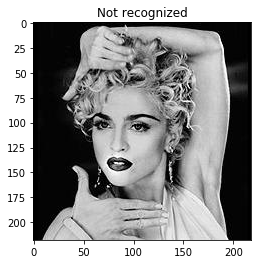

In [48]:
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

confidence_threshold = 0.5
avg_dist_threshold = 0.63

def who_is_it(image, database=database, clf=knn, encoder=encoder):

    embedding = image_to_embedding(image)
    if embedding is None:
        return None, None
    prediction = clf.predict([embedding])
    identity = idx_to_class[prediction[0]]
    
    verified = False
    dist = 0
    num = 0
    
    embeddings_to_verify = database[identity]
    total = len(embeddings_to_verify)
    
    for m in embeddings_to_verify:
        m_dist = distance(m, embedding)
        if m_dist < optimal_threshold:
            verified = True
            num += 1
        dist += m_dist
            
    confidence = num / total
    avg_dist = dist / total
    
    print('Avg dist: {:.4f} Confidence: {:.2f}% with {}'.format(avg_dist, confidence * 100, identity))
            
    if verified and confidence > confidence_threshold and avg_dist < avg_dist_threshold:
        print('Recognized as {}\n'.format(identity))
        return identity.replace('_', ' '), confidence
    else:
        return None, None

val_image = load_image(test_metadata[23].image_path())

identity, confidence = who_is_it(val_image)

plt.imshow(val_image)
if identity is not None:
    print('Confidence: {:.2f}%'.format(confidence * 100))
    plt.title('Recognized as {}'.format(identity))
else:
    plt.title('Not recognized')

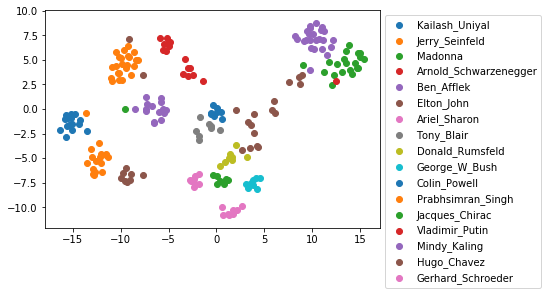

In [47]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded_train)

for i, t in enumerate(set(targets_train)):
    idx = targets_train == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

In [49]:
import time
from multiprocessing.dummy import Pool
import win32com.client as wincl

PADDING = 50
ready_to_detect_identity = True
windows10_voice_interface = wincl.Dispatch("SAPI.SpVoice")

def webcam_face_recognizer():
    """
    Runs a loop that extracts images from the computer's webcam and determines whether or not
    it contains the face of a person in our database.
    If it contains a face, an audio message will be played welcoming the user.
    If not, the program will process the next frame from the webcam
    """
    global ready_to_detect_identity
    
    print("Press ESC to exit\n")

    cv2.namedWindow("preview")
    vc = cv2.VideoCapture(0)

    face_cascade = cv2.CascadeClassifier('data/model/haarcascade_frontalface_default.xml')
    
    while vc.isOpened():
        _, frame = vc.read()
        image = frame

        # We do not want to detect a new identity while the program 
        # is in the process of identifying another person
        if ready_to_detect_identity:
            image = process_frame(image, frame, face_cascade)   
        
        key = cv2.waitKey(200)
        cv2.imshow("preview", image)

        if key == 27: # exit on ESC
            break
    cv2.destroyWindow("preview")

def process_frame(image, frame, face_cascade):
    """
    Determine whether the current frame contains the faces of people from our database
    """
    global ready_to_detect_identity
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Loop through all the faces detected and determine whether or not they are in the database
    results = []
    
    for (x, y, w, h) in faces:
        x1 = x - PADDING
        y1 = y - PADDING
        x2 = x + w + PADDING
        y2 = y + h + PADDING

        image = cv2.rectangle(frame, (x1, y1), (x2, y2), (0,0,255),2)

        identity, confidence = find_identity(frame, x1, y1, x2, y2)

        if identity is not None:
            results.append((identity, confidence))

    if len(results) > 0:
        cv2.imwrite('data/images/example.png', image)

        ready_to_detect_identity = False
        pool = Pool(processes=1)
        
        # We run this as a separate process so that the camera feedback does not freeze
        pool.apply_async(welcome_users, [results])
        
    return image

def find_identity(frame, x1, y1, x2, y2):
    """
    Determine whether the face contained within the bounding box exists in our database
    x1,y1_____________
    |                 |
    |                 |
    |_________________x2,y2
    """
    height, width, channels = frame.shape
    
    # The padding is necessary since the OpenCV face detector creates the bounding box around the face and not the head
    part_image = frame[max(0, y1):min(height, y2), max(0, x1):min(width, x2)]
    
    identity, confidence = who_is_it(part_image)
    if identity is None:
        return None, None
    else:
        return identity, confidence


def welcome_users(results):
    """ Outputs a welcome audio message to the users """
    global ready_to_detect_identity
    
    welcome_message = 'Hey '

    if len(results) == 1:
        identity, confidence = results[0]
        welcome_message += '{}, i see you.'.format(identity)
    else:
        for identity, confidence in results[:-1]:
            welcome_message += '{}, '.format(identity)
        identity, confidence = results[-1]
        welcome_message += 'and {}, '.format(identity)
        welcome_message += 'I see you all!'

    windows10_voice_interface.Speak(welcome_message)

    # Allow the program to start detecting identities again
    ready_to_detect_identity = True
    
webcam_face_recognizer()

Press ESC to exit

Avg dist: 0.5514 Confidence: 87.50% with Prabhsimran_Singh
Recognized as Prabhsimran_Singh

Avg dist: 0.6849 Confidence: 60.00% with Kailash_Uniyal
Avg dist: 0.8063 Confidence: 13.33% with Kailash_Uniyal
Avg dist: 0.7276 Confidence: 46.67% with Kailash_Uniyal
Avg dist: 1.0207 Confidence: 6.25% with Prabhsimran_Singh
Avg dist: 1.0012 Confidence: 8.33% with Jerry_Seinfeld
Avg dist: 1.0189 Confidence: 6.25% with Prabhsimran_Singh
Avg dist: 0.8945 Confidence: 13.33% with Ben_Afflek
Avg dist: 0.8712 Confidence: 20.83% with Jerry_Seinfeld
Avg dist: 0.9138 Confidence: 12.50% with Jerry_Seinfeld
Avg dist: 0.9709 Confidence: 6.67% with Kailash_Uniyal
Avg dist: 0.9704 Confidence: 8.33% with Jerry_Seinfeld
Avg dist: 0.8731 Confidence: 12.50% with Prabhsimran_Singh
Avg dist: 0.9876 Confidence: 6.25% with Prabhsimran_Singh
Avg dist: 0.9277 Confidence: 6.67% with Kailash_Uniyal
Avg dist: 0.8894 Confidence: 13.33% with Kailash_Uniyal
Avg dist: 1.0002 Confidence: 6.25% with Prabhsim